<a href="https://colab.research.google.com/github/shonyeajin/kaggle_intro/blob/main/U_Net_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yeajinshon","key":"5d9263b1f17cbceaaf414658d4f7f975"}'}

In [5]:
ls -1ha kaggle.json

kaggle.json


In [6]:
from IPython.core.display import JSON

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 1.97MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 35.8MB/s]
 96% 264M/276M [00:01<00:00, 163MB/s]
100% 276M/276M [00:01<00:00, 148MB/s]
 77% 7.00M/9.10M [00:00<00:00, 72.8MB/s]
100% 9.10M/9.10M [00:00<00:00, 77.3MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 167MB/s]
 92% 73.0M/79.1M [00:00<00:00, 69.7MB/s]
100% 79.1M/79.1M [00:00<00:00, 85.5MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 105MB/s]


In [9]:
!mkdir input

In [10]:
!mkdir input/stage1_train

In [ ]:
!unzip stage1_train.zip -d ./input/stage1_train

In [12]:
!mkdir input/stage1_test

In [ ]:
!unzip stage1_test.zip -d ./input/stage1_test

In [17]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

IMG_WIDTH=128
IMG_HEIGHT=128
IMG_CHANNELS=3
TRAIN_PATH='./input/stage1_train/'
TEST_PATH='./input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed=42
random.seed=seed
np.random.seed=seed

In [22]:
train_ids=next(os.walk(TRAIN_PATH))[1]
test_ids=next(os.walk(TEST_PATH))[1]

In [111]:
X_train=np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train=np.zeros((len(train_ids), IMG_HEIGHT,IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks...')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path=TRAIN_PATH+id_
  img=imread(path+'/images/'+id_+'.png')[:,:,:IMG_CHANNELS]
  img=resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n]=img
  mask=np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  for mask_file in next(os.walk(path+'/masks/'))[2]:
    mask_=imread(path+'/masks/'+mask_file)
    mask_=np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask=np.maximum(mask, mask_)
  Y_train[n]=mask



Getting and resizing train images and masks...


100%|██████████| 670/670 [07:27<00:00,  1.50it/s]


In [113]:
X_test=np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test=[]
print('Getting and resizing test images...')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path=TEST_PATH+id_
  img=imread(path +'/images/'+id_+'.png')[:,:,:IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img=resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n]=img
print('Done!')

Getting and resizing test images...


100%|██████████| 65/65 [00:02<00:00, 31.30it/s]

Done!


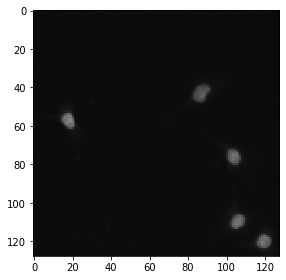

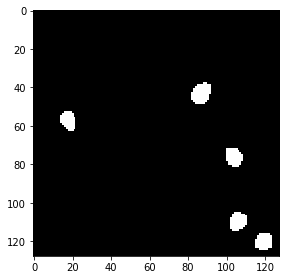

In [114]:
ix=random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [132]:
def mean_iou(y_true, y_pred):
  prec=[]
  for t in np.arange(0.5, 1, 0.05):
    y_pred_=tf.compat.v1.to_int32(y_pred > t)
    score, up_opt=tf.compat.v1.metrics.mean_iou(y_true, y_pred_,2)
    K.get_session().run(tf.local_variable_initializer())
    with tf.control_dependencies([up_opt]):
      score=tf.identity(score)
    prec.append(score)
  print(K.stack(prec))
  return K.mean(K.stack(prec), axis=0)

In [116]:
#Build U-Net model
from tensorflow.keras.layers import MaxPooling2D

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=Lambda(lambda x:x/255) (inputs)

c1=Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1=Dropout(0.1)(c1)
c1=Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)


In [117]:
c2=Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.1)(c2)
c2=Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)

In [118]:
c3=Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3=Dropout(0.2)(c3)
c3=Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)

In [119]:
c4=Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4=Dropout(0.2)(c4)
c4=Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4=MaxPooling2D((2,2))(c4)

In [120]:
c5=Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5=Dropout(0.3)(c5)
c5=Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)
p5=MaxPooling2D((2,2))(c5)

In [121]:
u6=Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6=concatenate([u6, c4])
c6=Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6=Dropout(0.2)(c6)
c6=Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

In [122]:
u7=Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7=concatenate([u7,c3])
c7=Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7=Dropout(0.2)(c7)
c7=Conv2D(64,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)


In [123]:
u8=Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8=concatenate([u8,c2])
c8=Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8=Dropout(0.1)(c8)
c8=Conv2D(32,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)


In [124]:
u9=Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9=concatenate([u9,c1], axis=3)
c9=Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9=Dropout(0.1)(c9)
c9=Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)


In [138]:
outputs=Conv2D(1,(1,1), activation='sigmoid')(c9)

from tensorflow.keras import Model

model=Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_6 (Lambda)              (None, 128, 128, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 128, 128, 16  448         ['lambda_6[0][0]']               
                                )                                                                 
                                                                                           

위에서 정의한 mean_iou함수를 metrics에 넣어 compile 했을 때 nonetype object is not collable erorr가 발생하여 우선 acc 로 변경하였음

In [139]:
earlystopper=EarlyStopping(patience=5, verbose=1)
checkpointer=ModelCheckpoint('model-dsbow12018-1.h5', verbose=1, save_best_only=True)
results=model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.2061 - acc: 0.9201
Epoch 00001: val_loss improved from inf to 0.21522, saving model to model-dsbow12018-1.h5
38/38 [==============================] - 7s 125ms/step - loss: 0.2061 - acc: 0.9201 - val_loss: 0.2152 - val_acc: 0.9300
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.1376 - acc: 0.9467
Epoch 00002: val_loss improved from 0.21522 to 0.17151, saving model to model-dsbow12018-1.h5
38/38 [==============================] - 4s 107ms/step - loss: 0.1376 - acc: 0.9467 - val_loss: 0.1715 - val_acc: 0.9411
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1295 - acc: 0.9497
Epoch 00003: val_loss improved from 0.17151 to 0.14909, saving model to model-dsbow12018-1.h5
38/38 [==============================] - 4s 106ms/step - loss: 0.1295 - acc: 0.9497 - val_loss: 0.1491 - val_acc: 0.9473
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.1073 - acc: 0.9580
Epo

In [140]:
model=load_model('model-dsbow12018-1.h5')
preds_train=model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val=model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test=model.predict(X_test, verbose=1)

3/3 [==============================] - 0s 170ms/step


In [142]:
preds_train_t=(preds_train>0.5).astype(np.uint8)
preds_val_t=(preds_val>0.5).astype(np.uint8)
preds_test_t=(preds_test>0.5).astype(np.uint8)

In [145]:
preds_test_upsampled=[]
for i in range(len(preds_test)):
  preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),(sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

In [146]:
preds_test_upsampled

[array([[0.01627555, 0.01712876, 0.00798482, ..., 0.0055331 , 0.01169552,
         0.01108255],
        [0.01699129, 0.01785618, 0.00825843, ..., 0.00577512, 0.01226676,
         0.01163443],
        [0.00757243, 0.00789186, 0.00348242, ..., 0.00257044, 0.00561221,
         0.00534982],
        ...,
        [0.00587703, 0.00609643, 0.00261723, ..., 0.00788819, 0.01435492,
         0.01319122],
        [0.01172484, 0.01226027, 0.00551459, ..., 0.0157997 , 0.02757964,
         0.0251022 ],
        [0.01098656, 0.01150664, 0.00522245, ..., 0.01481659, 0.025644  ,
         0.02329327]], dtype=float32),
 array([[0.08007399, 0.11257317, 0.08050342, ..., 0.11144936, 0.13070224,
         0.09123988],
        [0.11151408, 0.15677367, 0.11211212, ..., 0.15520862, 0.1820209 ,
         0.12706412],
        [0.11737174, 0.16499998, 0.11793003, ..., 0.17076278, 0.2028255 ,
         0.14179751],
        ...,
        [0.24414878, 0.35941017, 0.37661567, ..., 0.14874732, 0.21387467,
         0.1525343 

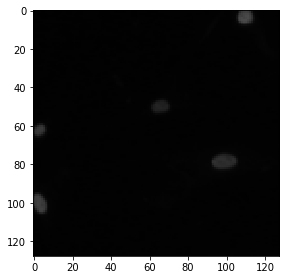

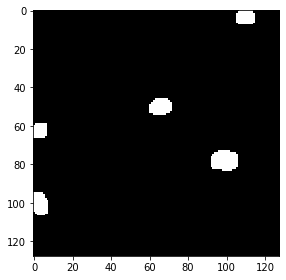

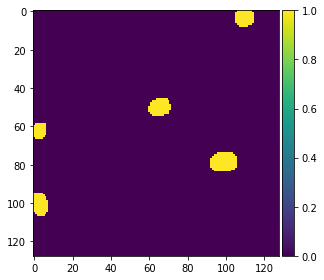

In [151]:
ix=random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

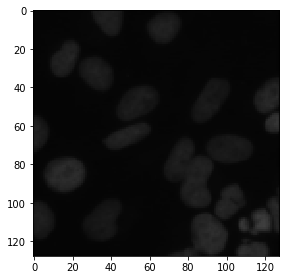

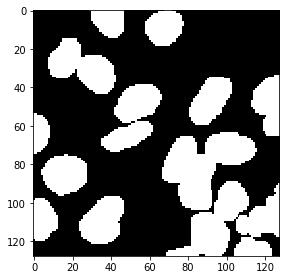

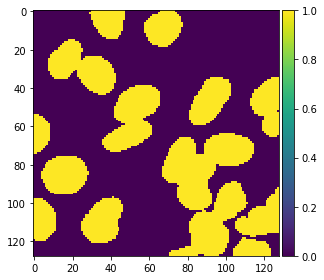

In [152]:
ix=random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()